<a href="https://colab.research.google.com/github/All4Nothing/pytorch-DL-programming/blob/main/Ch09_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache direc

In [46]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [ ]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

### GPU 확인하기

In [ ]:
# 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# 09. CNN을 활용한 이미지 인식

## 9.1 문제 정의하기  
CIFAR-10 데이터 셋을 사용  
- 32 x 32 화소의 컬러 이미지 데이터  
- airplane, automobile, bird 등 10종류의 카테고리  
- 훈련용 5만장과 검증용 1만장의 데이터가 공개되어 있음  
- 원본 데이터는 이미지 한 잔당 (3, 32, 32)의 3계 텐서로 표현

CNN에서는 '색, 가로, 세로'의 3계 텐서의 구조를 유지한 채 이미지를 처리한다. 두번째 층 이후에서는 '색'에 해당하는 인덱스는 더 이상 색의 의미를 갖지 않게 된다.  
깊이에 해당하는 이 인덱스는 '채널'로 불리는 것이 일반적이다.

## 9.3 CNN의 처리 개요

![AlexNet의 신경망](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99FEB93C5C80B5192E)
*AlexNet의 신경망 구조*

![전형적인 CNN의 구조](https://taewanmerepo.github.io/2018/01/cnn/head.png)
*전형적인 CNN의 구조*

### 합성곱 처리  
![합성곱처리](https://blog.kakaocdn.net/dn/bkZvKX/btqBFMSuybU/u6qWG3fwCyeSGAFlAiC7jK/img.png)
*합성곱 처리*  
- 합성곱 연산의 계산 순서는 왼쪽 위부터 시작
- 필터(=커널)의 크기만큼 입력데이터의 범위를 선택하고 같은 위치에 있는 원소끼리 곱(성분 곱, element-wise product)한 후 그 값들을 모두 합(sum)한다.  
- 이렇게 얻은 값을 해당 위치에 정렬하면 피처맵이 도출된다.  

*ardino.tistory.com/39* 참고

In [ ]:
data_root = './data'

# 샘플 손글씨 숫자 데이터 가져오기
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,
    download = True, transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)

100%|██████████| 9912422/9912422 [00:00<00:00, 103137896.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35670110.08it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26640567.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14744991.31it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# 대각선상에만 가중치를 갖는 특수한 합성곱 함수를 만듦
conv1 = nn.Conv2d(1, 1, 3)

# bias를 0으로
nn.init.constant_(conv1.bias, 0.0)

# weight를 특수한 값으로
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1

In [ ]:
# 손글씨 숫자에 3번 합성곱 처리를 함
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

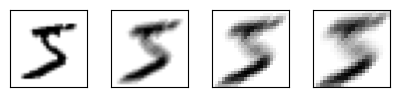

In [ ]:
# 결과 화면 출력

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

입력 채널은 통상 여러 개이며, 곱연산과 합연산은 전 채널에 걸쳐서 이뤄지므로, '커널'도 그에 따라 입력 채널의 분량만큼 있다. 출려 채널도 여러 개이므로, 커널은 전체 4계 텐서 구조를 갖는다.  
이 4계 텐서인 커널 배열이 신경망에서 '파라미터'에 해당하고, 이 텐서를 이루는 값이 학습 대상이 된다.  
합성곱 처리는 커널의 내용에 따라 특정한 기울기를 가진 직선이 강조되는 등, 도형의 특징량을 추출하는데 탁월하다. 그리고 학습은 커널이 위치를 이동하면서 이뤄지므로, **위치의 이동과 관련이 없는 특징량을 검출**할 수 있게 된다.  

### 풀링 처리  
![MaxPooling](https://codetorial.net/tensorflow/_images/convolutional_neural_network_03.png)
*Max Pooling의 개요*  
풀링 처리는 2x2처럼 작은 사각형 영역으로 이미지를 잘라내어, 그 범위 안에서 최댓값을 출력한다. 그 후 사각형 영역을 stride 만큼 옮긴 후 그 안에서 다시 최댓값을 출력한다. 이 과정을 반복한다  
합성곱 처리는, 화소를 한 개씩 옮겨가며 처리하는 과정이 대부분인 데에 반해, 풀링 처리는 중첩되는 영역이 없게끔 옮겨가며 처리하는 것이 일반적이다.  
사각형 영역의 사이즈는 대부분 2x2를 선호하므로, 가로세로가 모두 원본 이미지의 절반의 화소 수를 갖는 새로운 이미지가 완성된다.  
풀링 처리를 통해 이미지를 축소하는 것과 동일한 효과를 얻을 수 있다. 따라서, **물체의 크기와 관련이 없는 보편적인 특징량을 추출하는 것에 특화**되어 있다고 알려져있다.


## 9.4 파이토치에서 CNN을 구현하는 방법

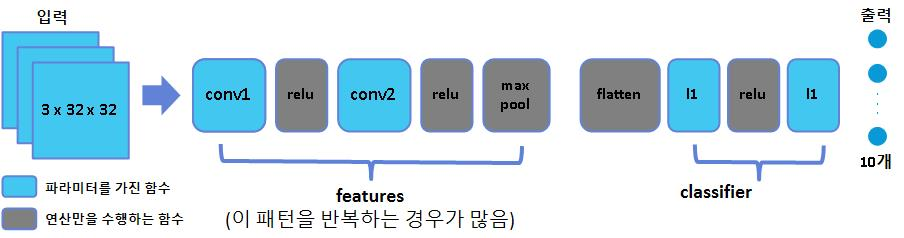
*그림 9-8 CNN의 전형적인 구성 예시*

**합성곱 처리**는 파이토치의 레이어 함수 중에서도 `nn.Conv2d`라고 하는 레이어 함수(합성곱 함수)가 담당 *conv1, conv2*  
**풀링 처리**는 `nn.MaxPool2d`라는 레이어 함수(풀링 함수)가 담당한다. *max pool*

**1계화 함수(flatten)**는 채널과 가로, 세로로 뻗는 '합성곱 함수', '풀링 함수'의 출력을 가로 1열의 1계 텐서로 만들어 주는 역할을 한다.  
분류 모델에서는 마지막 출력이 1계 텐서이므로, 어디선가는 이런 조작이 반드시 필요하다.  
파이토치 튜토리얼 등에서는, 대부분 view 함수로 이 조작을 구현하고 있지만, 이 책에서는 케라스와 같은 다른 프레임워크와의 호환성을 고려해 nn.Flatten이라는 레이어 함수를 사용한다.

### nn.Conv2d와 nn.MaxPool2d

In [ ]:
# CNN 모델 전반 부분, 레이어 함수 정의

conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True) ## inplace=True는 inplace 연산을 하겠다는 뜻
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2,2))
## nn.Conv2d(입력 채널 수, 출력 채널 수, 커널 사이즈)
## * 커널 사이즈 : 필터 역할을 하는 작은 정사각형의 한 변의 화소 수
## inplace 연산 : 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는 것을 의미 ex) x += 5 는 기존 x 데이터 대체

In [ ]:
# conv1 확인
print(conv1)

# conv1 내부 변수의 shape 확인
print(conv1.weight.shape) ## 4계의 인덱스를 갖는 4계 텐서
print(conv1.bias.shape)

# conv2 내부 변수의 shape 확인
print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


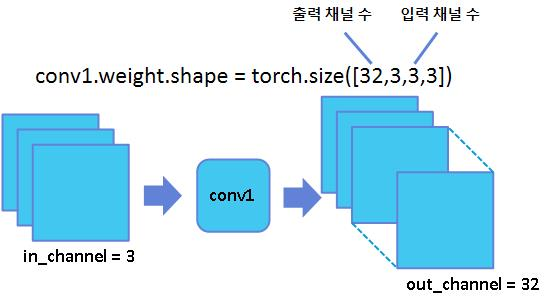  
*그림 9-9 conv1을 외부에서 본 경우의 거동*

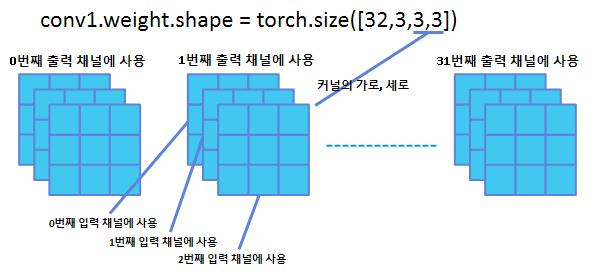  
*그림 9-10 conv1.weight의 내부구조*

In [ ]:
# conv1의 weight[0]는 0번째 출력 채널의 가중치
w = conv1.weight[0]

# weight[0]의 shape과 값 확인
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[ 0.1102 -0.134   0.1809]
  [-0.0567 -0.114   0.092 ]
  [-0.1411  0.0143 -0.1811]]

 [[ 0.0286  0.1798 -0.179 ]
  [ 0.0165  0.1261 -0.1251]
  [-0.1131  0.1575 -0.0229]]

 [[-0.1858  0.133   0.1634]
  [ 0.1785  0.0447 -0.1479]
  [-0.0646  0.1652 -0.133 ]]]


### 합성곱 처리와 풀링 처리 시뮬레이션

In [ ]:
# 더미로 입력과 같은 사이즈를 갖는 텐서를 생성
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [ ]:
# CNN 전반부 처리 시뮬레이션

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [ ]:
# 각 변수의 shape 확인 (코드9.4)

print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


(학습 데이터 건수, 채널 수, 가로 화소 수, 세로 화소 수)
- 첫번째 숫자인 학습 데이터의 건수는 일정하게 100
- 두번째 숫자인 채널 수는 RGB 채널이 3장이므로 3. 중간부터는 conv1과 conv2에서 모두 출력 채널 수 = 32로 설정했기 때문에 채널 수가 32
- 세번째와 네번째 숫자인 가로와 세로의 화소 수는 합성곱 함수를 한 번 거칠 때마다, 32->30, 30->28과 같이 2만큼의 간격으로 줄어들고 있다.  
이번 합성곱 처리의 가중치 행렬(커널)의 사이즈는 3x3이고, 합성곱 처리를 한 번 거칠 때마다 **'합성곱 처리 행렬의 사이즈 - 1'**만큼 출력 데이터의 화소 수가 줄어드는 것에 상응한다.
- 풀링 처리에서는 가로와 세로 모두 사이즈가 절반인 14가 되었다.
- ReLU 함수에서는 사이즈의 변화가 일어나지 않는다.

### nn.Sequential  
nn.Sequential이라는 클래스는 파이토치에서 '컨테이너'라고 불리는 클래스 중 하나이다.  
코드 9.4는 여러 함수의 합성 함수로 구성되어 있으며, 각 함수가 직렬로 이어져 있는 형태이다. 이와 같은 구조를 갖는 경우에는 nn.Sequential을 사용해서 나타낼 수 있다.

In [ ]:
# 함수 정의
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [ ]:
# 동작 테스트
outputs = features(inputs)

# 결과 확인
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten  
nn.Flatten 역시 레이어 함수(부품)다.

In [ ]:
# 함수 정의
flatten = nn.Flatten()

# 동작 테스트
outputs2 = flatten(outputs)

# 결과 확인
print(outputs.shape)
print(outputs2.shape) # 32 x 14 x 14 = 6272

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


## 9.5 공통 함수 사용하기
동일한 패턴으로 처리가 이뤄지는 부분 모두 뽑아내어, 각 패턴에 관해 공통 함수를 정의하기로 한다. 그리고 실습 코드에서는 공통 함수를 호출해서 사용하는 식으로 코드의 가독성을 높인다.

### eval_loss(손실 계산)  
인수로는 loader(데이터로더), device, net(모델 인스턴스), criterion(손실 함수)이 있다.  
먼저 데이터로더를 사용해서 입력 데이터와 정답 데이터를 가져오고, 입력 데이터와 모델 인스턴스로부터 예측값을 계산, 이후에 예측 값과 정답 데이터를 사용해서 손실을 계산하는 것이 처리의 흐름이다.

In [ ]:
# 손실 계산용
def eval_loss(loader, device, net, criterion):
  # 데이터로더에서 처음 한 개 세트를 가져옴
  for images, labels in loader:
    break
  # 디바이스 할당
  inputs = images.to(device)
  labels = labels.to(device)

  # 예측 계산
  outputs = net(inputs)

  # 손실 계산
  loss = criterion(outputs, labels)

  return loss

### fit(학습)  
'학습' 처리를 담당한다. 지금까지 반복 계산이라고 불러왔던 부분을 함수를 호출해서 한번에 처리하기 위한 목적
필요 인수  
- net: 학습 대상의 모델 인스턴스
- optimizer: 최적화 함수의 인스턴스
- criterion: 손실 함수의 인스턴스
- num_epochs: 반복 횟수
- train_loader: 훈련용 데이터로더
- test_loader: 검증용 데이터로더
- device: GPU 또는 CPU
- history: 계산 도중의 history

In [ ]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        # 예측 페이즈
        net.eval()
        count = 0
        ## net.train(), net.eval()은 모델 클래스를 정의할 때 사용하는 부모 클래스인 nn.Module에서 정의되어 있다.

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

### evaluate_history(학습 로그)
- history 앞부분과 마지막 부분을 print 함수로 표시해서 학습 결과의 개요를 표시
- 학습 곡선을 손실, 정확도 두 가지로 출력

In [ ]:
# 학습 로그 해석

def evaluate_history(history):
    # 손실과 정확도 확인
    print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}')
    print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 학습 곡선 출력(손실)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='훈련')
    plt.plot(history[:,0], history[:,3], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('손실')
    plt.title('학습 곡선(손실)')
    plt.legend()
    plt.show()

    # 학습 곡선 출력(정확도)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='훈련')
    plt.plot(history[:,0], history[:,4], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('정확도')
    plt.title('학습 곡선(정확도)')
    plt.legend()
    plt.show()

### show_images_labels(예측 결과 표시)
인수
- loader : 검증용 데이터로더
- classes : 정답 데이터에 대응하는 라벨 값의 리스트 (ex. plane, car, bird ..)
- net : 사전에 학습이 끝난 모델의 인스턴스. None을 넘기면 정답 데이터만 표시되며, 학습 전에 데이터의 형태를 확인하고 싶은 경우에 사용한다.
- device : 예측 계사에 사용하는 디바이스

In [ ]:
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 처음 1세트를 가져오기
    for images, labels in loader:
        break
    # 표시 수는 50개
    n_size = min(len(images), 50)

    if net is not None:
      # 디바이스 할당
      inputs = images.to(device)
      labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시함
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 정답인지 아닌지 색으로 구분함
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net이 None인 경우는 정답 라벨만 표시
        else:
          ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

### torch_seed(난수 초기화)

In [ ]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # 프로퍼티 설정
    ## 파이토치에서는 GPU를 사용해서 계산하는 경우, 난수의 시드를 지정하는 것만으로는 동일한 결과를 얻을 수 없을 때도 있다. 다음 두 줄의 코드는 이런 현상을 방지하기 위한 설정이다.
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## 9.6 데이터 준비

### Transforms 정의

In [ ]:
# Transforms의 정의
## 데이터 전처리

# transformer1 1계 텐서화

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 정규화만 실시

# 검증 데이터용 : 정규화만 실시
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

### 데이터셋 정의

In [ ]:
# 데이터 취득용 함수 datasets

data_root = './data'

# 훈련 데이터셋 (1계 텐서 버전)
train_set1 = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform1)

# 검증 데이터셋 (1계 텐서 버전)
test_set1 = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform1)

# 훈련 데이터셋 (3계 텐서 버전)
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True,
    download = True, transform = transform2)

# 검증 데이터셋 (3계 텐서 버전)
test_set2 = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform2)

100%|██████████| 170498071/170498071 [00:02<00:00, 64137119.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 데이터셋 확인

In [ ]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


### 데이터로더 정의

In [ ]:
# 데이터로더 정의

# 미니 배치 사이즈 지정
batch_size = 100

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
## shuffle=True 설정 시 매 epoch 마다 셔플하므로, 검증용은 셔플 x
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False)

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False)

In [ ]:
# train_loader1에서 한 세트 가져오기
for images1, labels1 in train_loader1:
    break

# train_loader2에서 한 세트 가져오기
for images2, labels2 in train_loader2:
    break

# 각 데이터의 shape 확인
print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


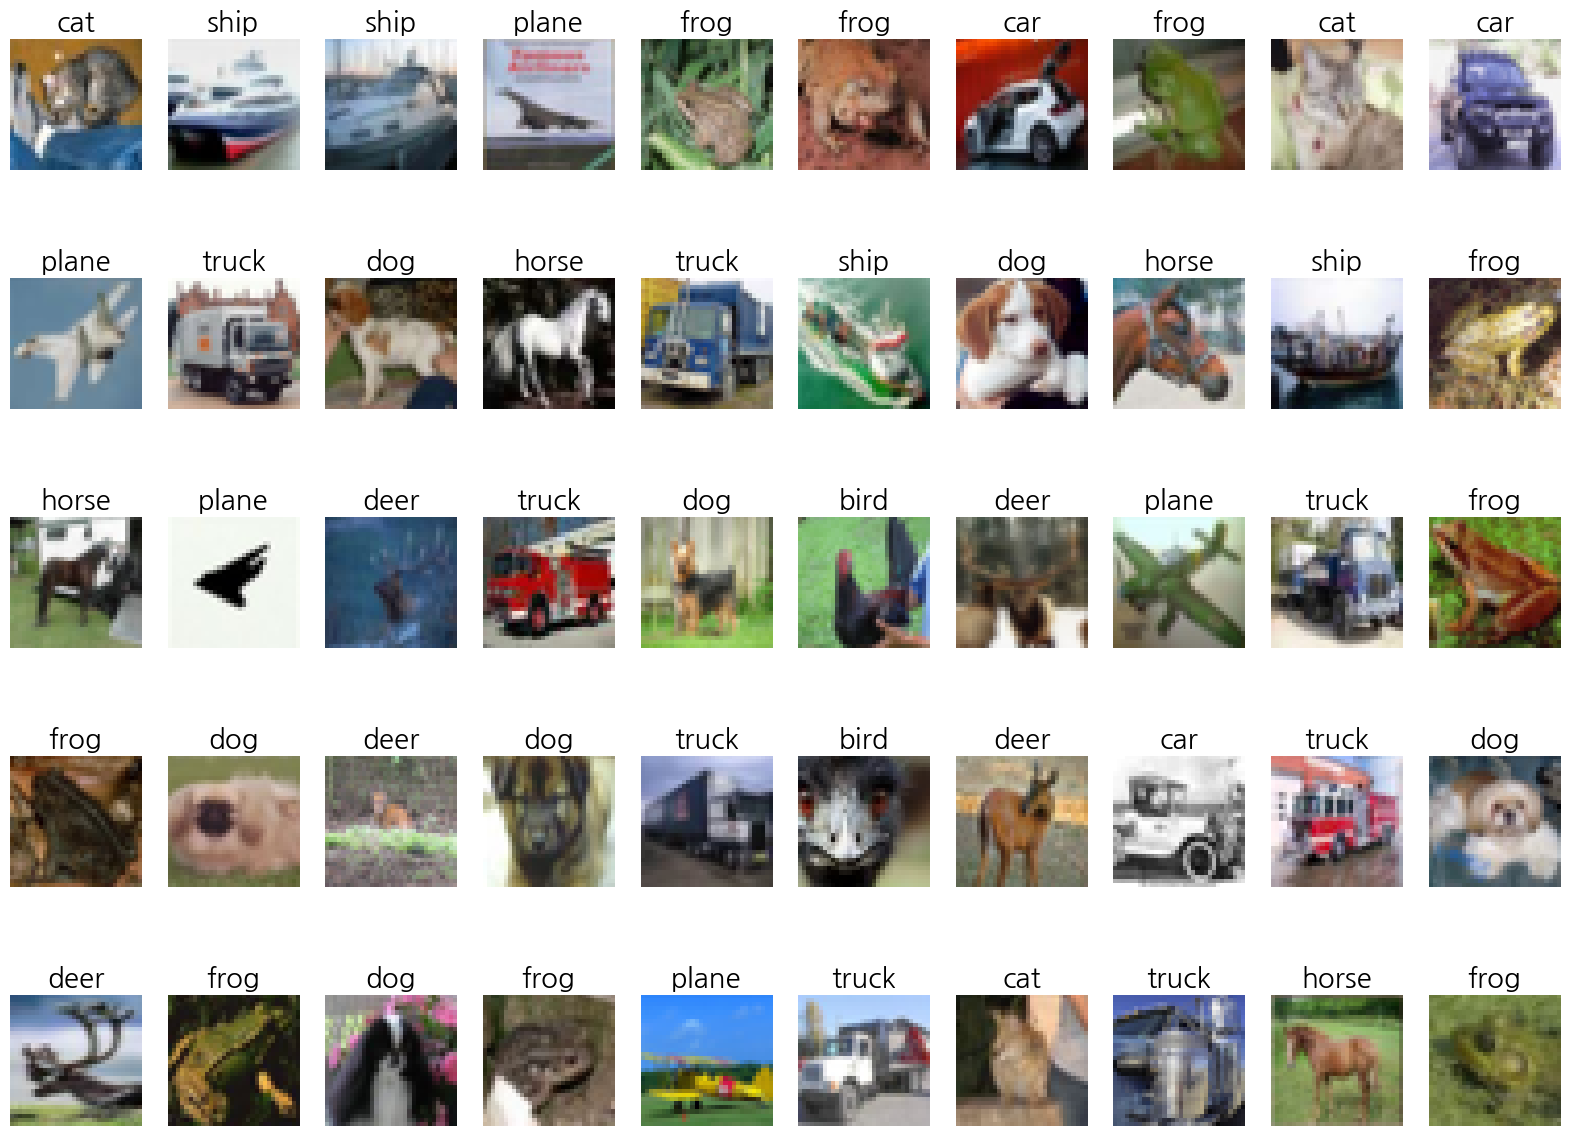

In [ ]:
# 정답 라벨 정의
## 튜플 : 불변. 적은 메모리 사용. 리스트와 유사 사용
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 검증 데이터의 처음 50개를 출력
show_images_labels(test_loader2, classes, None, None)

## 9.7 모델 정의(전결합형 FNN)

### 학습용 파라미터 설정

In [ ]:
# 입력 차원수는 3*32*32=3072
n_input = image1.view(-1).shape[0]

# 출력 차원수
# 분류 클래스의 수이므로　10
n_output = len(set(list(labels1.data.numpy())))
## set : List와 비슷하지만, 요소들이 순서대로 저장되지 않아 indexing이 존재하지 않는다. 동일 값 요소가 1개 이상 존재할 수 없다.

# 은닉층의 노드수
n_hidden = 128

# 결과 확인
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [ ]:
# 모델 정의
# 3072입력 10출력 1은닉층을 포함한 신경망 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 은닉층 정의(은닉층의 노드수 : n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 출력층의 정의
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

## 모델 인스턴스 생성과 GPU 할당

In [ ]:
# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
# 모델 개요 표시 1

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [ ]:
# 모델 개요 표시 2

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

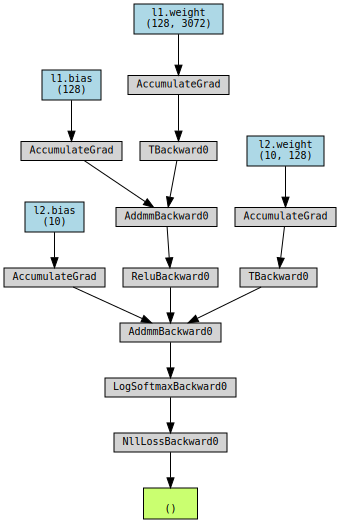

In [ ]:
# 손실 계산
loss = eval_loss(test_loader1, device, net, criterion)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.8 결과(전결합형)

### 학습

In [47]:
# 난수 초기화
torch_seed()

# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 50

# 평가 결과 기록
history = np.zeros((0,5))

# 학습
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01950 acc: 0.32218 val_loss: 0.01794, val_acc: 0.37710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01738 acc: 0.39598 val_loss: 0.01684, val_acc: 0.41850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01655 acc: 0.42398 val_loss: 0.01622, val_acc: 0.43860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01602 acc: 0.44256 val_loss: 0.01583, val_acc: 0.45150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01563 acc: 0.45540 val_loss: 0.01553, val_acc: 0.46170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01532 acc: 0.46760 val_loss: 0.01530, val_acc: 0.46830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01505 acc: 0.47688 val_loss: 0.01512, val_acc: 0.47400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01480 acc: 0.48632 val_loss: 0.01493, val_acc: 0.47750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01457 acc: 0.49624 val_loss: 0.01480, val_acc: 0.48740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01435 acc: 0.50422 val_loss: 0.01463, val_acc: 0.48860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01413 acc: 0.51134 val_loss: 0.01450, val_acc: 0.49600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01394 acc: 0.52010 val_loss: 0.01437, val_acc: 0.50270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01375 acc: 0.52644 val_loss: 0.01425, val_acc: 0.50610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01357 acc: 0.53494 val_loss: 0.01423, val_acc: 0.50550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.01341 acc: 0.53912 val_loss: 0.01407, val_acc: 0.51290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.01324 acc: 0.54558 val_loss: 0.01401, val_acc: 0.51140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.01307 acc: 0.55128 val_loss: 0.01390, val_acc: 0.51540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01293 acc: 0.55656 val_loss: 0.01388, val_acc: 0.51440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.01278 acc: 0.56236 val_loss: 0.01379, val_acc: 0.52030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01264 acc: 0.56728 val_loss: 0.01381, val_acc: 0.51790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01251 acc: 0.57094 val_loss: 0.01371, val_acc: 0.51790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01237 acc: 0.57734 val_loss: 0.01367, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01225 acc: 0.58026 val_loss: 0.01363, val_acc: 0.52600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.01213 acc: 0.58432 val_loss: 0.01355, val_acc: 0.52560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.01200 acc: 0.59158 val_loss: 0.01352, val_acc: 0.52720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.01189 acc: 0.59336 val_loss: 0.01351, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01178 acc: 0.59884 val_loss: 0.01350, val_acc: 0.52480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.01167 acc: 0.60248 val_loss: 0.01344, val_acc: 0.53090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.01156 acc: 0.60544 val_loss: 0.01342, val_acc: 0.52810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01145 acc: 0.60928 val_loss: 0.01346, val_acc: 0.52970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01135 acc: 0.61432 val_loss: 0.01340, val_acc: 0.53070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.01124 acc: 0.61838 val_loss: 0.01338, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01115 acc: 0.62168 val_loss: 0.01338, val_acc: 0.53100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.01105 acc: 0.62536 val_loss: 0.01341, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.01095 acc: 0.62826 val_loss: 0.01340, val_acc: 0.52540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01086 acc: 0.63254 val_loss: 0.01333, val_acc: 0.53220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.01076 acc: 0.63596 val_loss: 0.01338, val_acc: 0.52790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.01067 acc: 0.64010 val_loss: 0.01335, val_acc: 0.53050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01059 acc: 0.64190 val_loss: 0.01340, val_acc: 0.53000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.01050 acc: 0.64562 val_loss: 0.01347, val_acc: 0.52380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.01041 acc: 0.64988 val_loss: 0.01340, val_acc: 0.52930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01033 acc: 0.65164 val_loss: 0.01347, val_acc: 0.52790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.01025 acc: 0.65352 val_loss: 0.01345, val_acc: 0.52600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.01016 acc: 0.65558 val_loss: 0.01345, val_acc: 0.52770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.01007 acc: 0.66062 val_loss: 0.01345, val_acc: 0.52770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.01000 acc: 0.66182 val_loss: 0.01343, val_acc: 0.52980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00993 acc: 0.66458 val_loss: 0.01346, val_acc: 0.52860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00985 acc: 0.66942 val_loss: 0.01351, val_acc: 0.53130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00977 acc: 0.67160 val_loss: 0.01362, val_acc: 0.52010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00970 acc: 0.67264 val_loss: 0.01352, val_acc: 0.53220


### 평가

초기상태 : 손실 : 0.01794  정확도 : 0.37710
최종상태 : 손실 : 0.01352  정확도 : 0.53220


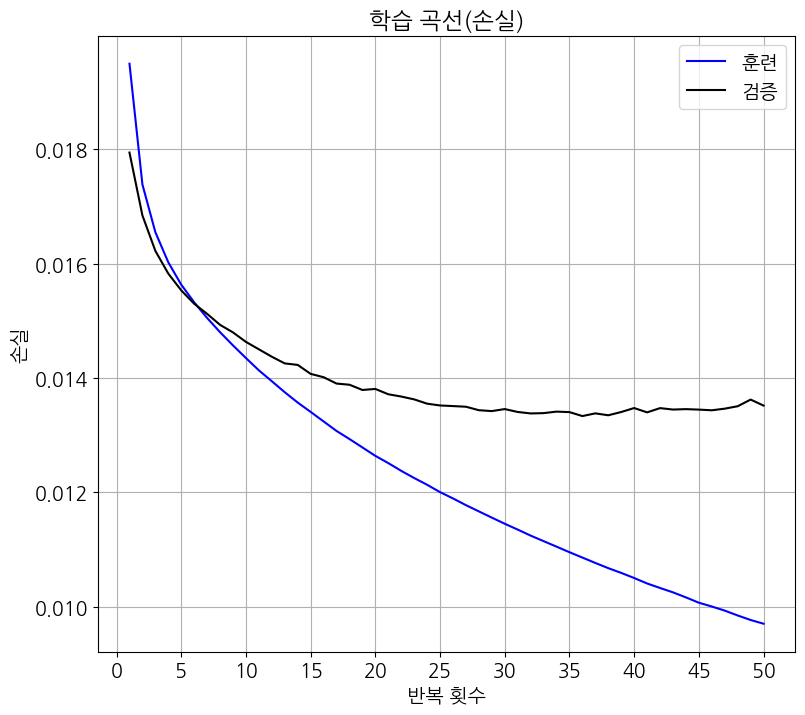

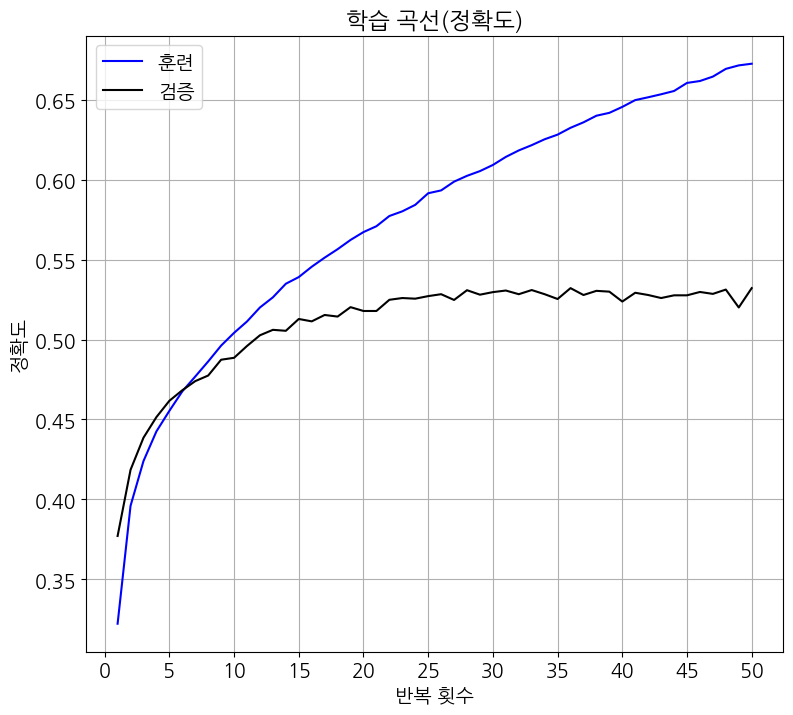

In [48]:
# 평가

evaluate_history(history)

- 검증 데이터에 대한 그래프로부터 반복 횟수 30회 부근에서 학습이 정체
- 검증 데이터에 대한 정확도는 최대 53% 정도에 그침

## 9.9 모델 정의(CNN)

In [49]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden) # 6272 : 시뮬레이션의 결과 이용 또는 머릿속으로 해당 요소 수 계산
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)

    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

### 모델 인스턴스 생성

In [50]:
# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [51]:
# 모델 개요 표시 1

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [52]:
# 모델 개요 표시2

summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [100, 10]                 804,234
Total params: 823,626
Trainable params: 823,626
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

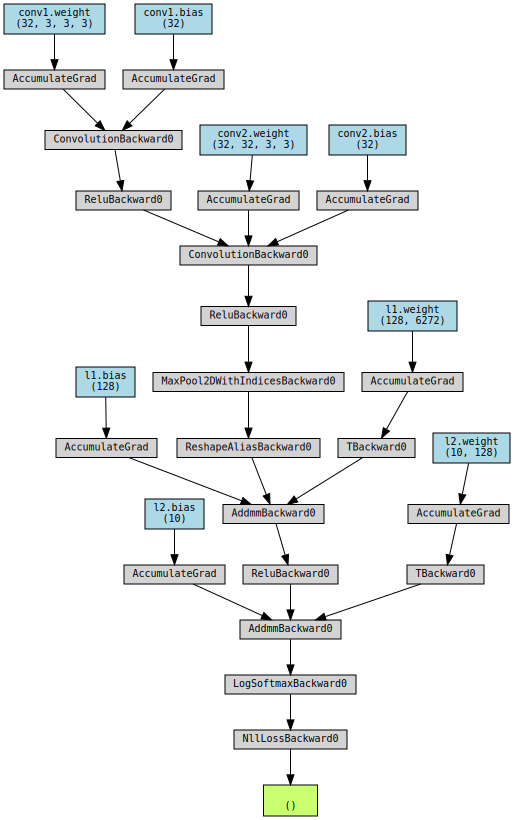

In [53]:
# 손실 계산
loss = eval_loss(test_loader2, device, net, criterion)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.10 결과(CNN)

### 모델 초기화와 학습

In [54]:
# 난수 초기화
torch_seed()

# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 50

# 평가 결과 기록
history2 = np.zeros((0,5))

# 학습
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02082 acc: 0.26084 val_loss: 0.01866, val_acc: 0.34690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37296 val_loss: 0.01677, val_acc: 0.40950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43058 val_loss: 0.01531, val_acc: 0.45960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47320 val_loss: 0.01448, val_acc: 0.49010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01408 acc: 0.49936 val_loss: 0.01370, val_acc: 0.51260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01350 acc: 0.52108 val_loss: 0.01331, val_acc: 0.52650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01303 acc: 0.53764 val_loss: 0.01293, val_acc: 0.53840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01252 acc: 0.55482 val_loss: 0.01254, val_acc: 0.55170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01205 acc: 0.57400 val_loss: 0.01236, val_acc: 0.56080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01158 acc: 0.59202 val_loss: 0.01185, val_acc: 0.58010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01117 acc: 0.60856 val_loss: 0.01166, val_acc: 0.58730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01078 acc: 0.62390 val_loss: 0.01171, val_acc: 0.58150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01036 acc: 0.63662 val_loss: 0.01112, val_acc: 0.60710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00998 acc: 0.64962 val_loss: 0.01088, val_acc: 0.61330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00959 acc: 0.66454 val_loss: 0.01113, val_acc: 0.60460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00922 acc: 0.67720 val_loss: 0.01058, val_acc: 0.63050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00881 acc: 0.69298 val_loss: 0.01072, val_acc: 0.62320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00846 acc: 0.70502 val_loss: 0.01013, val_acc: 0.64720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00807 acc: 0.71970 val_loss: 0.01019, val_acc: 0.64200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00772 acc: 0.73090 val_loss: 0.01047, val_acc: 0.63660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00737 acc: 0.74268 val_loss: 0.00997, val_acc: 0.65790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00700 acc: 0.75770 val_loss: 0.01015, val_acc: 0.65330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00672 acc: 0.76766 val_loss: 0.00995, val_acc: 0.65660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00635 acc: 0.77998 val_loss: 0.01001, val_acc: 0.66050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00601 acc: 0.79298 val_loss: 0.00999, val_acc: 0.66800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00566 acc: 0.80634 val_loss: 0.01050, val_acc: 0.64800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00537 acc: 0.81612 val_loss: 0.01057, val_acc: 0.66380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00506 acc: 0.82836 val_loss: 0.01125, val_acc: 0.64130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00471 acc: 0.83970 val_loss: 0.01052, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00438 acc: 0.85290 val_loss: 0.01100, val_acc: 0.65860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00405 acc: 0.86442 val_loss: 0.01105, val_acc: 0.66300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00377 acc: 0.87340 val_loss: 0.01146, val_acc: 0.65660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00347 acc: 0.88430 val_loss: 0.01128, val_acc: 0.66770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00319 acc: 0.89420 val_loss: 0.01275, val_acc: 0.64410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00290 acc: 0.90594 val_loss: 0.01310, val_acc: 0.64320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00265 acc: 0.91472 val_loss: 0.01286, val_acc: 0.65310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00235 acc: 0.92652 val_loss: 0.01280, val_acc: 0.66460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00212 acc: 0.93414 val_loss: 0.01321, val_acc: 0.66090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00189 acc: 0.94354 val_loss: 0.01362, val_acc: 0.65800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00171 acc: 0.95190 val_loss: 0.01444, val_acc: 0.65410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00143 acc: 0.96116 val_loss: 0.01526, val_acc: 0.65180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00132 acc: 0.96432 val_loss: 0.01647, val_acc: 0.63760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00104 acc: 0.97552 val_loss: 0.01747, val_acc: 0.63320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00088 acc: 0.98122 val_loss: 0.01612, val_acc: 0.66060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00078 acc: 0.98440 val_loss: 0.01653, val_acc: 0.65960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00060 acc: 0.98972 val_loss: 0.01701, val_acc: 0.65760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00043 acc: 0.99516 val_loss: 0.01742, val_acc: 0.66150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00033 acc: 0.99710 val_loss: 0.01792, val_acc: 0.66360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00027 acc: 0.99806 val_loss: 0.01872, val_acc: 0.66280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00023 acc: 0.99876 val_loss: 0.01882, val_acc: 0.66010


### 평가

초기상태 : 손실 : 0.01866  정확도 : 0.34690
최종상태 : 손실 : 0.01882  정확도 : 0.66010


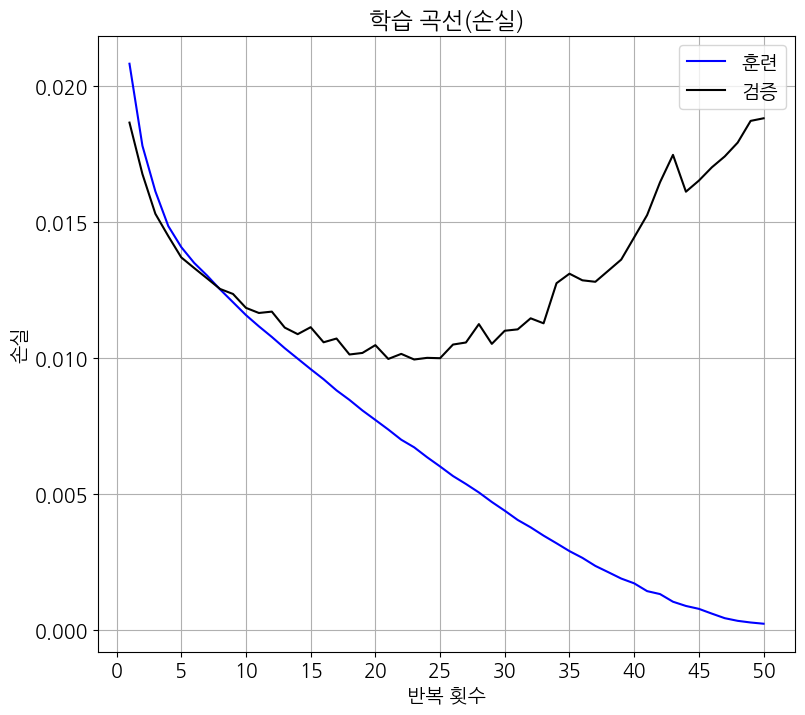

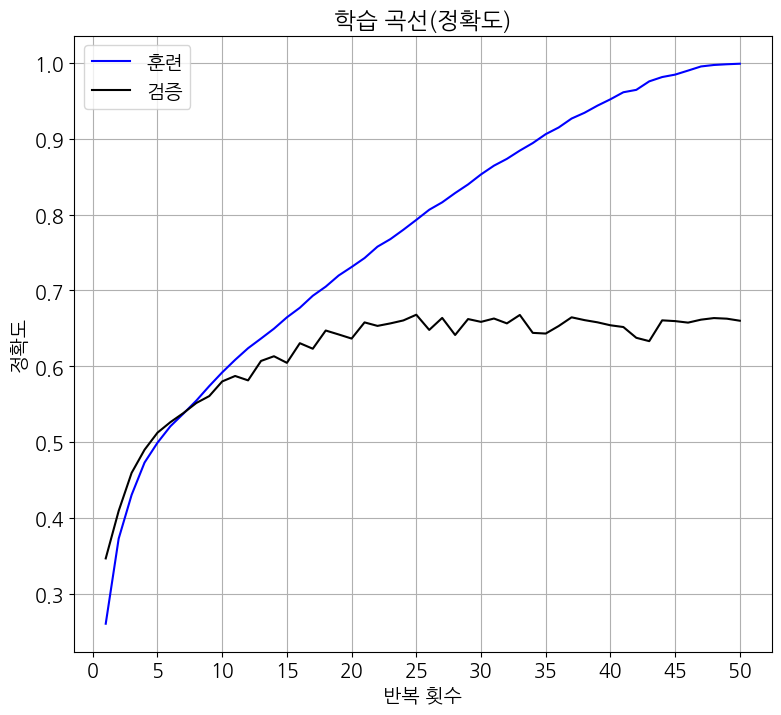

In [55]:
# 평가

evaluate_history(history2)

***정확도 53% → 66%***

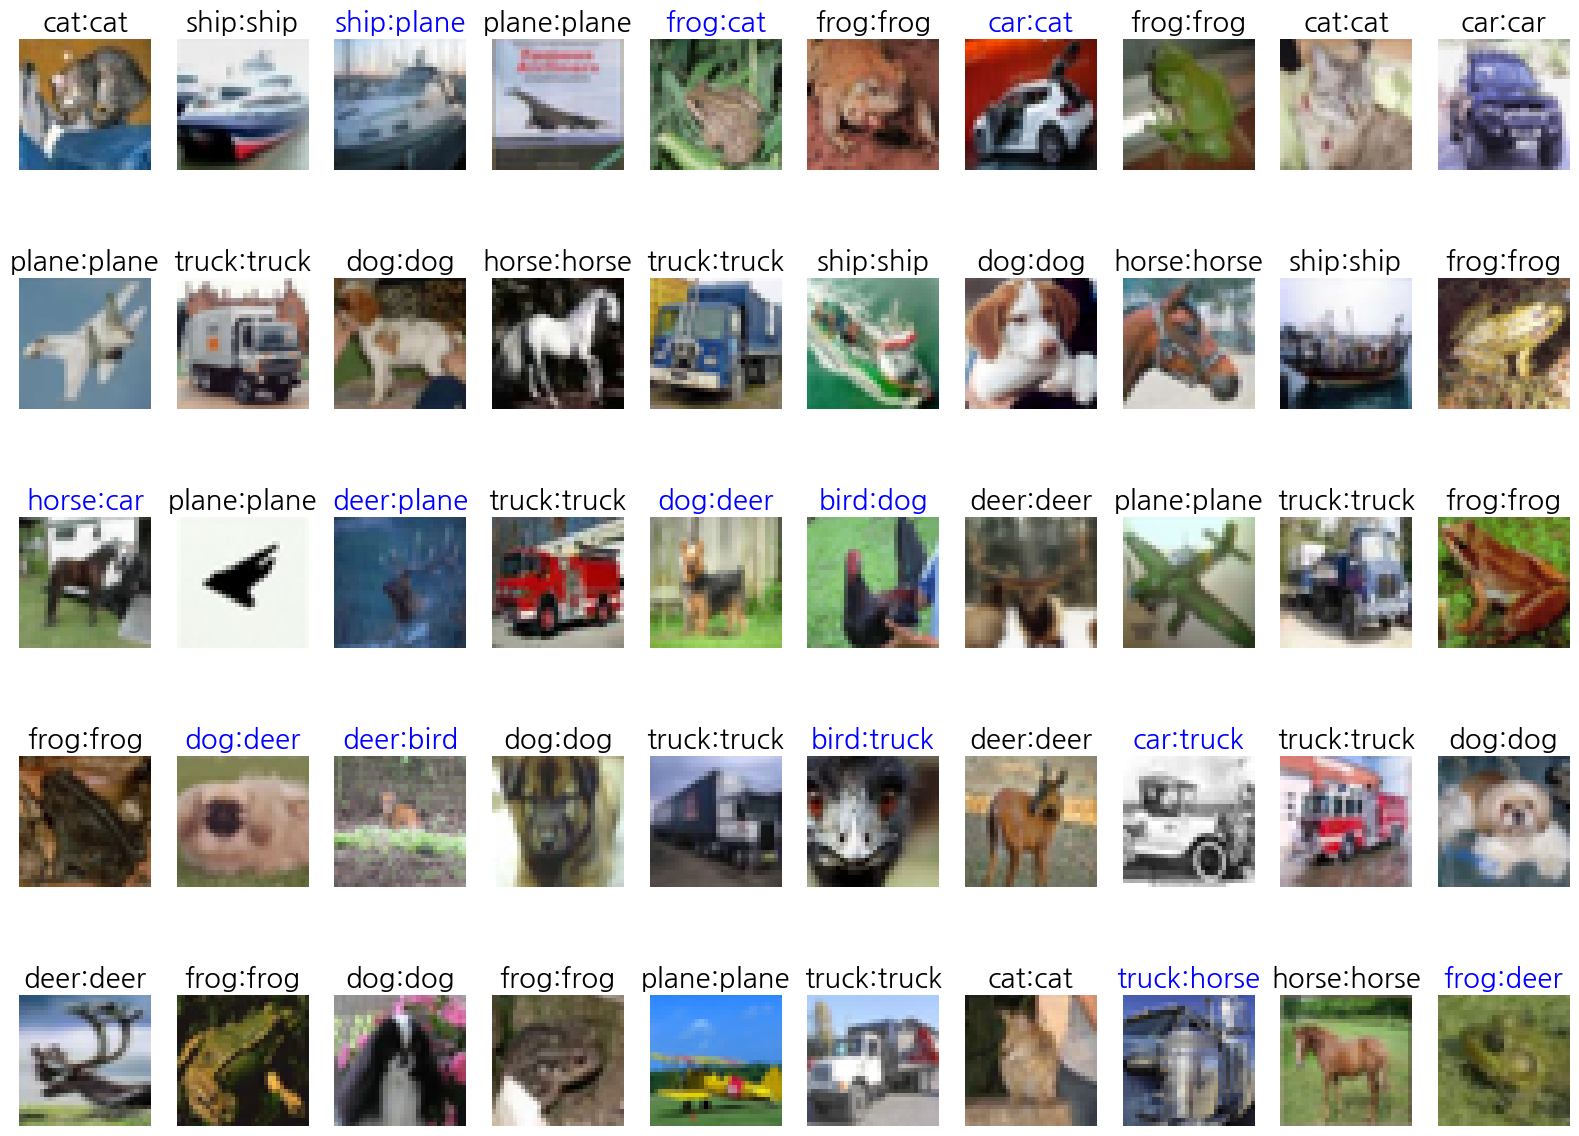

In [56]:
# 처음 50개 데이터 표시

show_images_labels(test_loader2, classes, net, device)

*50개의 데이터에 대해 올바른 예측 35개, 잘못 예측 15개 → 정확도 70%*